**author**: ken@weecology.org<br>
**date**: 7 Oct 2017<br>
**language**: Python 2.7<br>
**license**: BSD3<br>

## mle_curve_fits.ipynb

Alpha-diversity maximum likelihood estimation (MLE). MLE fits of Laplace and Gaussian distributions to OTU richness vs. pH and temperature.

In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.optimize import curve_fit
from math import pi
%matplotlib inline

In [2]:
path_map = '../../data/mapping-files/emp_qiime_mapping_qc_filtered.tsv'
path_adiv = '../../data/alpha-div/emp.90.min25.deblur.withtax.onlytree_5000.txt'


def xfrm(X, _max): return -np.log(_max-np.array(X))
#def ivrt(Y, _max): return _max-np.exp(-np.array(Y))

def laplace_reg(X, loc, scale, const):
    laplace = const*(1/(2*scale)) * np.exp((-np.abs(X - loc))/scale)
    return laplace

def norm_reg(X, mu, std, const):
    norm = const * (1/(np.sqrt(2*(std**2)*pi))) * np.exp(-((X - mu)**2)/(2*(std**2)))
    return norm


df_map = pd.read_csv(path_map, sep='\t', index_col=0, low_memory=False)
df_adiv = pd.read_csv(path_adiv, sep='\t', index_col=0)
df_merged = pd.merge(df_map, df_adiv, how='inner', left_index=True, right_index=True)

/Users/luke.thompson/miniconda3/envs/emp-py2/lib/python2.7/site-packages/ipykernel/__main__.py:8: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
/Users/luke.thompson/miniconda3/envs/emp-py2/lib/python2.7/site-packages/ipykernel/__main__.py:52: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


[  9.04085460e+00   1.07845415e+01   5.71367009e+04]
[  9.60069627e+00   8.69506619e+00   4.70701878e+04]


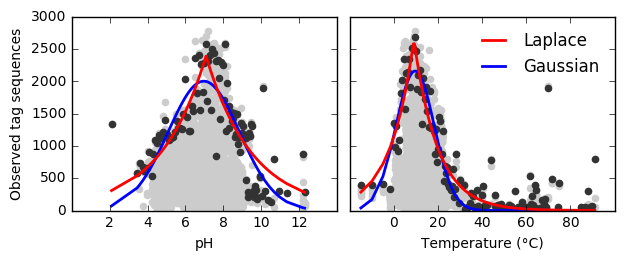

In [4]:
fig = plt.figure(figsize=(7, 6))

# PH

fig.add_subplot(2, 2, 1)

df = pd.concat([df_merged['ph'], df_merged['observed_otus']], axis=1)
df = df.convert_objects(convert_numeric=True).dropna()

X, Y = (np.array(t) for t in zip(*sorted(zip(df['ph'], df['observed_otus']))))

Xi = xfrm(X, max(X)*1.05)
bins = np.linspace(np.min(Xi), np.max(Xi)+1, 300)
ii = np.digitize(Xi, bins)

pcts = np.array([np.percentile(Y[ii==i], 99) for i in range(1, len(bins)) if len(Y[ii==i]) > 0])
xran = np.array([np.mean(X[ii==i]) for i in range(1, len(bins)) if len(Y[ii==i]) > 0])

plt.scatter(X, Y, color='0.8')
plt.scatter(xran, pcts, s=20, color='0.2')

#http://docs.scipy.org/doc/numpy-1.9.3/reference/generated/numpy.random.laplace.html
#http://stackoverflow.com/questions/6620471/fitting-empirical-distribution-to-theoretical-ones-with-scipy-python
#http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html#scipy.stats.norm
#http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.laplace.html

loc, scale, const = 7.3, 15, 1
popt, pcov = curve_fit(laplace_reg, xran, pcts, [loc, scale, const])
#print popt
model = laplace_reg(xran, *popt)
plt.plot(xran, model, color='r', lw=2, label='Laplace', zorder=2)

mu, std, const = 7.3, 5, 1
popt, pcov = curve_fit(norm_reg, xran, pcts, [mu, std, const])
#print popt
model = norm_reg(xran, *popt)
plt.plot(xran, model, color='b', lw=2, label='Gaussian', zorder=1)

plt.ylim(0, 3000)
plt.xlim(0.01, 13.99)
plt.ylabel('Observed tag sequences')
plt.xlabel('pH')
#plt.legend(loc='upper right')
#plt.rc('legend',**{'fontsize':8})
#plt.legend(frameon=False)

# TEMPERATURE

fig.add_subplot(2, 2, 2)

df = pd.concat([df_merged['temperature_deg_c'], df_merged['observed_otus']], axis=1)
df = df.convert_objects(convert_numeric=True).dropna()

X, Y = (np.array(t) for t in zip(*sorted(zip(df['temperature_deg_c'], df['observed_otus']))))

Xi = xfrm(X, max(X)*1.05)
bins = np.linspace(np.min(Xi), np.max(Xi)+1, 600)
ii = np.digitize(Xi, bins)

pcts = np.array([np.percentile(Y[ii==i], 99) for i in range(1, len(bins)) if len(Y[ii==i]) > 0])
xran = np.array([np.mean(X[ii==i]) for i in range(1, len(bins)) if len(Y[ii==i]) > 0])

plt.scatter(X, Y, color='0.8')
plt.scatter(xran, pcts, s=20, color='0.2')

loc, scale, const = 10, 15, 1
popt, pcov = curve_fit(laplace_reg, xran, pcts, [loc, scale, const])
print popt
model = laplace_reg(xran, *popt)
plt.plot(xran, model, color='r', lw=2, label='Laplace', zorder=2)

mu, std, const = 10, 5, 1
popt, pcov = curve_fit(norm_reg, xran, pcts, [mu, std, const])
print popt
model = norm_reg(xran, *popt)
plt.plot(xran, model, color='b', lw=2, label='Gaussian', zorder=1)

plt.ylim(0, 3000)
plt.xlim(-19.99, 99.99)
plt.legend(loc='upper right')
plt.legend(frameon=False)
frame1 = plt.gca()
frame1.axes.yaxis.set_ticklabels([])
plt.xlabel(u'Temperature (\N{DEGREE SIGN}C)')

# # OXYGEN

# fig.add_subplot(2, 2, 3)

# df = pd.concat([df_merged['oxygen_mg_per_l'], df_merged['observed_otus']], axis=1)
# df = df.convert_objects(convert_numeric=True).dropna()

# X, Y = (np.array(t) for t in zip(*sorted(zip(df['oxygen_mg_per_l'], df['observed_otus']))))

# Xi = xfrm(X, max(X)*1.05)
# bins = np.linspace(np.min(Xi), np.max(Xi)+1, 300)
# ii = np.digitize(Xi, bins)

# pcts = np.array([np.percentile(Y[ii==i], 99) for i in range(1, len(bins)) if len(Y[ii==i]) > 0])
# xran = np.array([np.mean(X[ii==i]) for i in range(1, len(bins)) if len(Y[ii==i]) > 0])

# plt.scatter(X, Y, color='0.8')
# plt.scatter(xran, pcts, s=20, color='0.2')

# #http://docs.scipy.org/doc/numpy-1.9.3/reference/generated/numpy.random.laplace.html
# #http://stackoverflow.com/questions/6620471/fitting-empirical-distribution-to-theoretical-ones-with-scipy-python
# #http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html#scipy.stats.norm
# #http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.laplace.html

# loc, scale, const = 7.3, 15, 1
# popt, pcov = curve_fit(laplace_reg, xran, pcts, [loc, scale, const])
# #print popt
# model = laplace_reg(xran, *popt)
# plt.plot(xran, model, color='r', lw=2, label='Laplace', zorder=2)

# mu, std, const = 7.3, 5, 1
# popt, pcov = curve_fit(norm_reg, xran, pcts, [mu, std, const])
# #print popt
# model = norm_reg(xran, *popt)
# plt.plot(xran, model, color='b', lw=2, label='Gaussian', zorder=1)

# plt.ylim(0, 3000)
# plt.xlim(0.01, 19.99)
# plt.ylabel('Observed tag sequences')
# plt.xlabel('Oxygen (mg/L)')
# #plt.legend(loc='upper right')
# #plt.rc('legend',**{'fontsize':8})
# #plt.legend(frameon=False)

# # NITRATE

# fig.add_subplot(2, 2, 4)

# df_merged['nitrate_umol_per_l'] = [np.nan if x == 0 else x for x in df_merged['nitrate_umol_per_l']]

# df_merged['log_nitrate'] = [np.log10(x) for x in df_merged['nitrate_umol_per_l']]

# df = pd.concat([df_merged['log_nitrate'], df_merged['observed_otus']], axis=1)
# df = df.convert_objects(convert_numeric=True).dropna()

# X, Y = (np.array(t) for t in zip(*sorted(zip(df['log_nitrate'], df['observed_otus']))))

# Xi = xfrm(X, max(X)*1.05)
# bins = np.linspace(np.min(Xi), np.max(Xi)+1, 600)
# ii = np.digitize(Xi, bins)

# pcts = np.array([np.percentile(Y[ii==i], 99) for i in range(1, len(bins)) if len(Y[ii==i]) > 0])
# xran = np.array([np.mean(X[ii==i]) for i in range(1, len(bins)) if len(Y[ii==i]) > 0])

# plt.scatter(X, Y, color='0.8')
# plt.scatter(xran, pcts, s=20, color='0.2')

# loc, scale, const = 10, 15, 1
# popt, pcov = curve_fit(laplace_reg, xran, pcts, [loc, scale, const])
# print popt
# model = laplace_reg(xran, *popt)
# plt.plot(xran, model, color='r', lw=2, label='Laplace', zorder=2)

# mu, std, const = 10, 5, 1
# popt, pcov = curve_fit(norm_reg, xran, pcts, [mu, std, const])
# print popt
# model = norm_reg(xran, *popt)
# plt.plot(xran, model, color='b', lw=2, label='Gaussian', zorder=1)

# plt.ylim(0, 3000)
# plt.xlim(-3.5, 3.9)
# frame1 = plt.gca()
# frame1.axes.yaxis.set_ticklabels([])
# plt.xlabel(u'log10(Nitrate (\N{MICRO SIGN}mol/L))')


# SAVE PDF
plt.subplots_adjust(wspace=0.05, hspace=0.4)
plt.savefig('otus_vs_env_fits.pdf', bbox_inches = "tight")
